<a href="https://colab.research.google.com/github/LHMade/LH-Made-Cookies/blob/main/sori_LH_Made_Cookies_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
uploaded = files.upload()

Saving 2.성남시_상권정보.csv to 2.성남시_상권정보.csv
Saving 3.성남시_상가개폐업.csv to 3.성남시_상가개폐업.csv
Saving 4.성남시_표제부.csv to 4.성남시_표제부.csv
Saving 5.성남시_층별개요.csv to 5.성남시_층별개요.csv
Saving 7.성남시_지식산업센터.csv to 7.성남시_지식산업센터.csv
Saving 8.성남시_개별공시지가.csv to 8.성남시_개별공시지가.csv
Saving 9.성남시_버스정류장.csv to 9.성남시_버스정류장.csv
Saving 10.성남시_지하철역.csv to 10.성남시_지하철역.csv


In [16]:
!pip install geopandas xgboost lightgbm

In [30]:
import gc
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from scipy.spatial import cKDTree
from xgboost import XGBRegressor
import lightgbm as lgb
import tensorflow as tf

In [31]:
# 경로 설정
file_paths = {
    "거주인구": "/content/1.성남시_거주인구.csv",
    "상권정보": "/content/2.성남시_상권정보.csv",
    "상가개폐업": "/content/3.성남시_상가개폐업.csv",
    "층별개요": "/content/5.성남시_층별개요.csv",
    "지식산업센터": "/content/7.성남시_지식산업센터.csv",
    "개별공시지가": "/content/8.성남시_개별공시지가.csv",
    "버스정류장": "/content/9.성남시_버스정류장.csv",
    "지하철역": "/content/10.성남시_지하철역.csv"
}

In [32]:
# TensorFlow retracing 방지
@tf.function(reduce_retracing=True)
def safe_predict(model, data):
    return model.predict(data, batch_size=32)

In [33]:
# 데이터 로드, 전처리
df_population = pd.read_csv(file_paths["거주인구"], encoding="utf-8-sig").fillna(0)
df_population["total_population"] = df_population.iloc[:, 2:].sum(axis=1)
df_population = df_population.groupby("gid")["total_population"].sum().reset_index()

df_land_value = pd.read_csv(file_paths["개별공시지가"], encoding="utf-8-sig").fillna(0)
df_land_value_avg = df_land_value.groupby("bjd_nm")["land_value"].mean().reset_index()
df_land_value_avg["land_value_change"] = df_land_value_avg["land_value"].pct_change().fillna(0)

df_floors = pd.read_csv(file_paths["층별개요"], encoding="utf-8-sig", low_memory=False).fillna(0)
df_floors_grouped = df_floors.groupby("plat_plc")["flr_num"].max().reset_index()

df_shop = pd.read_csv(file_paths["상가개폐업"], encoding="utf-8-sig").fillna(0)
df_shop_grouped = df_shop.groupby("addr")["biz_stts_nm"].count().reset_index()
df_shop_grouped.rename(columns={"biz_stts_nm": "num_business_changes"}, inplace=True)

def convert_to_gdf(df, lon_col, lat_col):
    df = df.dropna(subset=[lon_col, lat_col])
    df["geometry"] = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf_industrial = convert_to_gdf(pd.read_csv(file_paths["지식산업센터"], encoding="utf-8-sig"), "lon", "lat")
gdf_industrial = gdf_industrial.merge(df_land_value_avg, left_on="addr", right_on="bjd_nm", how="left")
gdf_industrial = gdf_industrial.merge(df_population, left_on="addr", right_on="gid", how="left")
gdf_industrial = gdf_industrial.merge(df_floors_grouped, left_on="addr", right_on="plat_plc", how="left")
gdf_industrial = gdf_industrial.merge(df_shop_grouped, left_on="addr", right_on="addr", how="left")

In [34]:
# 거리 계산, 공간 분석
gdf_bus = convert_to_gdf(pd.read_csv(file_paths["버스정류장"], encoding="utf-8-sig"), "lon", "lat")
gdf_subway = convert_to_gdf(pd.read_csv(file_paths["지하철역"], encoding="utf-8-sig"), "lon", "lat")

def calculate_nearest_distance(source_gdf, target_gdf):
    return [target_gdf.distance(pt).min() * 111 for pt in source_gdf.geometry]

gdf_industrial["bus_distance_km"] = calculate_nearest_distance(gdf_industrial, gdf_bus)
gdf_industrial["subway_distance_km"] = calculate_nearest_distance(gdf_industrial, gdf_subway)

def count_nearby_stations(center_gdf, station_gdf, radius=1000):
    tree = cKDTree(list(zip(station_gdf.geometry.x, station_gdf.geometry.y)))
    counts = [len(tree.query_ball_point((pt.x, pt.y), radius)) for pt in center_gdf.geometry]
    return counts

gdf_industrial["bus_station_count"] = count_nearby_stations(gdf_industrial, gdf_bus)
gdf_industrial["subway_station_count"] = count_nearby_stations(gdf_industrial, gdf_subway)

gdf_industrial["vacancy_rate"] = 1 - (gdf_industrial["cpn_in_2406"] / gdf_industrial["tot_cpn"])
gdf_industrial.fillna(0, inplace=True)

<ipython-input-34-7e9e325418ef>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return [target_gdf.distance(pt).min() * 111 for pt in source_gdf.geometry]
<ipython-input-34-7e9e325418ef>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return [target_gdf.distance(pt).min() * 111 for pt in source_gdf.geometry]
<ipython-input-34-7e9e325418ef>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_industrial.fillna(0, inplace=True)


In [35]:
# 새로운 Feature 추가
gdf_industrial["log_bus_distance"] = np.log1p(gdf_industrial["bus_distance_km"])
gdf_industrial["log_subway_distance"] = np.log1p(gdf_industrial["subway_distance_km"])
gdf_industrial["transport_score"] = gdf_industrial["bus_station_count"] + gdf_industrial["subway_station_count"]

In [36]:
# XGBoost & RandomForest 기반
gdf_industrial = gdf_industrial.select_dtypes(include=[np.number])

xgb_selector = XGBRegressor(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42)
xgb_selector.fit(gdf_industrial.drop(columns=["vacancy_rate"]), gdf_industrial["vacancy_rate"])
feature_importances = pd.Series(xgb_selector.feature_importances_, index=gdf_industrial.columns.drop("vacancy_rate"))
selected_features = feature_importances.nlargest(5).index.tolist()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(gdf_industrial[selected_features])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, gdf_industrial["vacancy_rate"], test_size=0.2, random_state=42)

In [37]:
# Stacking Model 최적화
stacking_model = StackingRegressor(
    estimators=[
        ("rf", RandomForestRegressor(n_estimators=500, max_depth=6, random_state=42)),
        ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42)),
        ("lgb", lgb.LGBMRegressor(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42))
    ],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 4
[LightGBM] [Info] Start training from score 0.564526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=6,
                                                     n_estimators=500,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gro...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.02, max_depth=6,
                                             n_estimators=500,
                                             random_state=42))],
                  final_estimator=Ridge())

In [38]:
# 모델 평가
stacking_pred = stacking_model.predict(X_test)
(mean_absolute_error(y_test, stacking_pred), r2_score(y_test, stacking_pred))

(0.07478436431475172, 0.8432894730596454)

In [39]:
# 예측값 계산
stacking_pred = stacking_model.predict(X_test)

In [40]:
# 훈련 데이터와 테스트 데이터 R² 비교
train_r2 = stacking_model.score(X_train, y_train)
test_r2 = stacking_model.score(X_test, y_test)

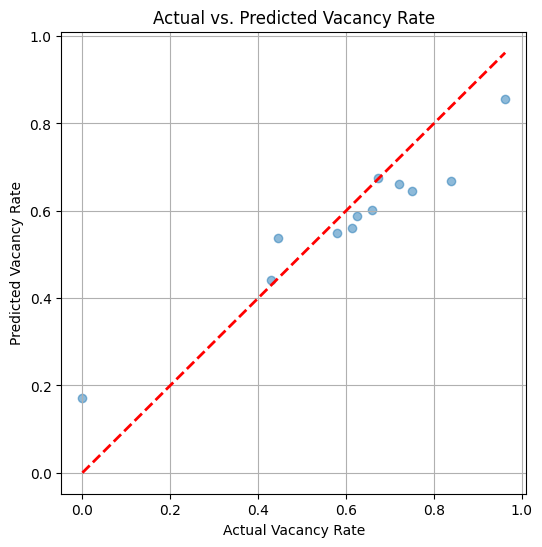

In [41]:
# 예측값 vs 실제값 시각화
plt.figure(figsize=(6,6))
plt.scatter(y_test, stacking_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Vacancy Rate")
plt.ylabel("Predicted Vacancy Rate")
plt.title("Actual vs. Predicted Vacancy Rate")
plt.grid(True)
plt.show()

In [42]:
# MSE, RMSE 계산
mse = np.mean((y_test - stacking_pred) ** 2)
rmse = np.sqrt(mse)

(train_r2, test_r2, mse, rmse)

(0.8823773680388726,
 0.8432894730596454,
 0.008453213503065646,
 0.09194135904513075)